##Task 1: Spectrogram of FM signal

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
#select the audio file by running this cell.
from google.colab import files
uploaded = files.upload()
#the audio file will be added to the current directory

Saving FMcapture_91_89_5_sec.dat to FMcapture_91_89_5_sec.dat


In [ ]:
y = np.fromfile('FMcapture_91_89_5_sec.dat', dtype='uint8')
y=y-127.5
y = y[::2] + 1j * y[1::2]


In [ ]:
print("Total number of samples:",len(y))

Total number of samples: 12500000


Clearly the file is sampled at a sample rate of 2500000 samples/second. Since the duration of the file is 5 seconds, the total number of samples will be 5*2500000 samples = 12500000 samples.

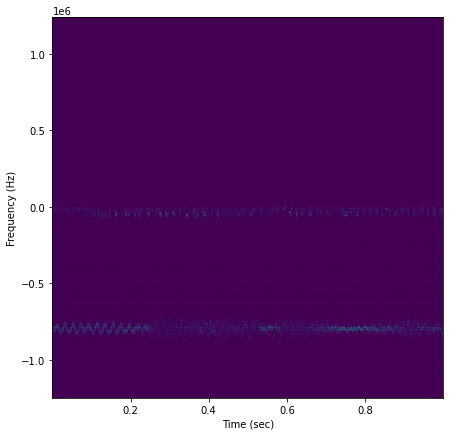

In [ ]:
from scipy import signal
fs=2500000
# plotting the spectrogram of first second of the file i.e we are considering the first 2500000 samples out of the total 12500000 samples.
f, t, Sxx = signal.spectrogram(y[0:2500000],fs,return_onesided=False)
figure = plt.figure(figsize=(7,7))
plt.pcolormesh(t, f, Sxx, shading='gouraud')
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (sec)')
plt.show()



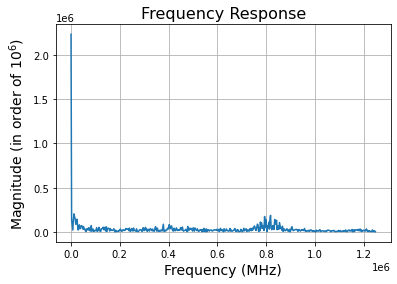

In [ ]:
# plotting the frequency response of the file
(w, H) = signal.freqz(y,1,whole=False,fs=fs)
plt.plot(w,abs(H))
plt.title("Frequency Response",fontsize="16")
plt.xlabel("Frequency (MHz)",fontsize="14")
plt.ylabel("Magnitude (in order of $10^{6}$)",fontsize="14")
plt.grid(True)
plt.show()

Clearly we can see that our center frequency is at 0Hz.

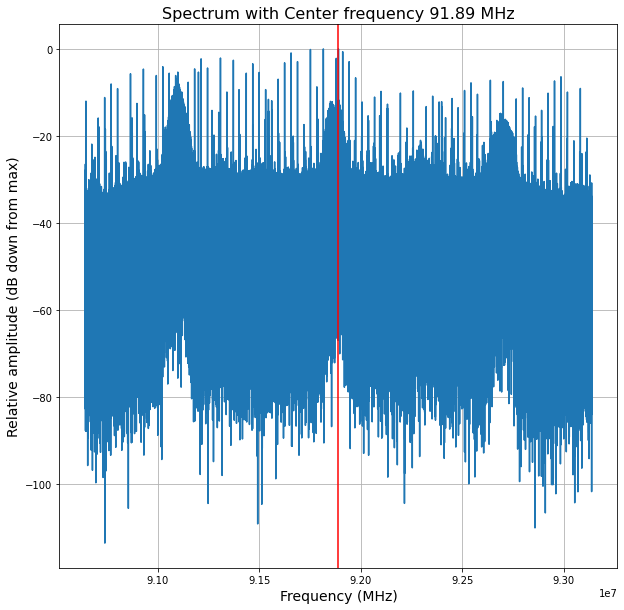

In [ ]:
# plotting the frequency spectrum
#from scipy import fft
#from scipy.fft import fftshift
from scipy.fftpack import fft,fftshift
def plot_FFT_IQ(x,no,nf,fs,fo):
  # Plots the FFT of sampled IQ data
  """
                x  -- input signal
                fs -- sampling frequency (MHz) 
                fo -- center frequency (MHz)
                no -- first sample (start time = n0/fs)
                nf -- block size for transform (signal duration = nf/fs)
                
  """
  # This extracts a segment of x starting at n0 sample and considers total nf samples, and plots the FFT
  x_segment=x[no : int(no + nf)]  #extracts a small segment of data from signal form n0 and total of nf samples.
  x_segment_fft =fftshift(fft(x_segment))
  x_fft_normalized = abs(x_segment_fft)/(max(abs(x_segment_fft)))
  x_mag = 20*np.log10(x_fft_normalized)

  Low_freq=(fo-fs/2)   # lowest frequency to plot
  High_freq=(fo+fs/2)  # highest frequency to plot

  N=np.array(x_mag.shape)
  freq=np.arange(0,N)
  freq=np.arange(0,N)*fs/N+Low_freq
  figure = plt.figure(figsize=(10,10))
  plt.plot(freq,x_mag)
  plt.axvline(x = fo, color = 'r', label = 'axvline - full height')
  plt.grid(True)
  

fo=91.89e6
fs=2.5e6
nf=5*fs  # considering entire file i.e considering all the samples

plot_FFT_IQ(y,0,nf,fs,fo)
plt.xlabel('Frequency (MHz)',fontSize ="14")
plt.ylabel('Relative amplitude (dB down from max)',fontSize="14")
plt.title("Spectrum with Center frequency {} MHz".format(fo/(10**6)),fontsize="16")
plt.show()

##Task 2: FM signal demodulation

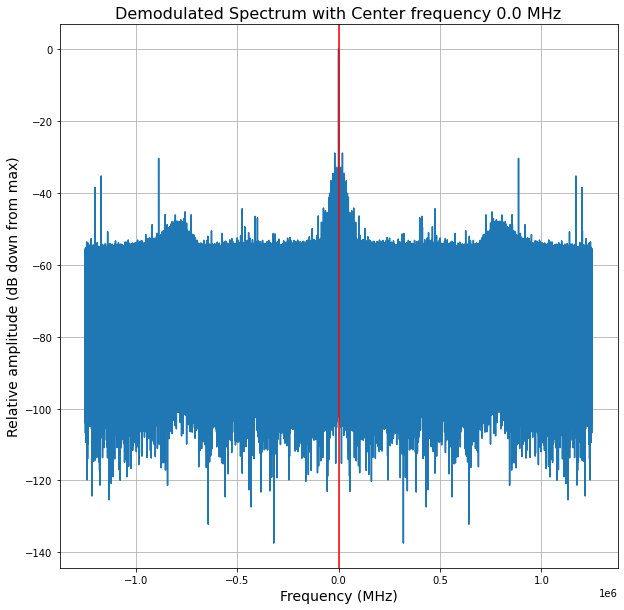

In [ ]:
# FM demodulate the 91.89 FM broadcast. To do this, we first want to center the 91.89 FM station at 0 Hz (DC). Since the center frequency is at 0 Hz, there is no need of shifting.

fmdem= np.angle(y[1:]*np.conj(y[0:-1])) # compute the finite difference by computing the product y[n]y*[n - 1] and then computing the phase.

fo=0
fs=2.5e6
nf=5*fs  # considering upto 3 seconds

plot_FFT_IQ(fmdem,0,nf,fs,fo)
plt.xlabel('Frequency (MHz)',fontSize ="14")
plt.ylabel('Relative amplitude (dB down from max)',fontSize="14")
plt.title("Demodulated Spectrum with Center frequency {} MHz".format(fo/(10**6)),fontsize="16")
plt.show()

Clearly we can observe that the spectrum is symmetrical about 0 Hz. So the demodulated signal is purely real and is no longer a complex IQ signal.

## Task 3: Listen to radio

In [ ]:
#select the audio file by running this cell.
from google.colab import files
uploaded = files.upload()
#the audio file will be added to the current directory

Saving Lpfilter_Num_2_5_M_2.5M.mat to Lpfilter_Num_2_5_M_2.5M.mat


In [ ]:
!sudo apt-get install libportaudio2
!pip install sounddevice

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libportaudio2 is already the newest version (19.6.0-1).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.


In [ ]:
import scipy.io
from scipy.io import loadmat
import sounddevice as sd
import soundfile as sf
from scipy.io.wavfile import write

In [ ]:
#  filter designed with fs=2.4e6
lpfilter =loadmat('Lpfilter_Num_2_5_M_2.5M.mat')

lpfilter1 = lpfilter['Num_2_5_M'].reshape(1, -1)[0]

fm_audo=scipy.signal.lfilter(lpfilter1,1,fmdem)

# changing the sampling frequency into the audible range

fm_audio_down=scipy.signal.resample_poly(fm_audo,48000,2500000)

# Converting into the .wav file to listen/plat the audio

write("fm_audio_down_wave.wav", 48000, fm_audio_down)

# filename = 'fm_audio_down_wave.wav'

data, fs = sf.read('fm_audio_down_wave.wav', dtype='float32')
#sd.play(data, fs)
status = sd.wait()